In [67]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [68]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [69]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [70]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [71]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [72]:
# View all of the classes that automap found
from sqlalchemy import create_engine, MetaData
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
metadata = MetaData(bind=engine)
metadata.reflect()
table_names = metadata.tables.keys()
table_names

dict_keys(['measurement', 'station'])

In [73]:
# Save references to each table
Station = Base.classes.station
Measurement = Base.classes.measurement

In [74]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [75]:
# Find the most recent date in the data set.
recent_date = session.query(func.max(Measurement.date)).first()
recent_date

('2017-08-23',)

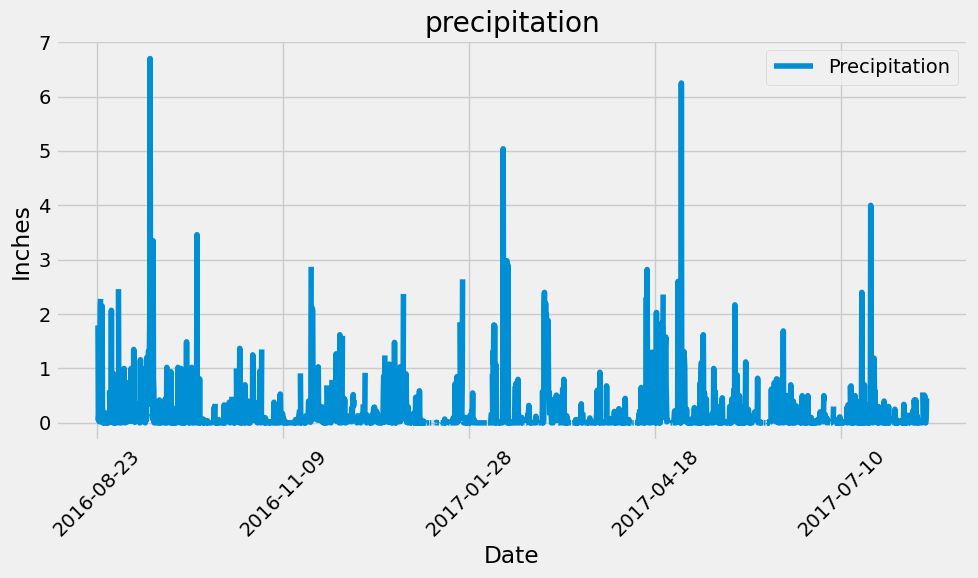

In [76]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
last_date = session.query(func.max(Measurement.date)).scalar()
last_date = pd.to_datetime(last_date)  # Converting datetime object
one_year_ago = last_date - pd.DateOffset(years=1)
one_year_ago_str = one_year_ago.strftime('%Y-%m-%d')

# Perform a query to retrieve the data and precipitation scores
precipitation_data = (
    session.query(Measurement.date, Measurement.prcp)
    .filter(Measurement.date >= one_year_ago_str)  # Use the string representation
    .all()
)
# Save the query results as a Pandas DataFrame. Explicitly set the column names
precipitation_df = pd.DataFrame(precipitation_data, columns=['Date', 'Precipitation'])

# Sort the dataframe by date
precipitation_df = precipitation_df.sort_values(by='Date')

# Use Pandas Plotting with Matplotlib to plot the data
precipitation_df.plot(x='Date', y='Precipitation', figsize=(10, 6))
plt.title("precipitation")
plt.xlabel("Date")
plt.ylabel("Inches")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [77]:
precipitation_summary = precipitation_df['Precipitation'].describe()
precipitation_summary

count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: Precipitation, dtype: float64

# Exploratory Station Analysis

In [78]:
# Design a query to calculate the total number of stations in the dataset
engine = create_engine('sqlite:///Resources/hawaii.sqlite')
Session = sessionmaker(bind=engine)
session = Session()

total_num_stations = session.query(func.count(Station.id)).scalar()
total_num_stations

9

In [79]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
engine = create_engine('sqlite:///Resources/hawaii.sqlite')
Session = sessionmaker(bind=engine)
session = Session()

most_active_stations = (
    session.query(Measurement.station, func.count(Measurement.station))
    .group_by(Measurement.station)
    .order_by(func.count(Measurement.station).desc())
    .all()
)

most_active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [80]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
engine = create_engine('sqlite:///Resources/hawaii.sqlite')
Session = sessionmaker(bind=engine)
session = Session()

most_active_station_id = most_active_stations[0][0]

temperature_stats = (
    session.query(
        func.min(Measurement.tobs),
        func.max(Measurement.tobs),
        func.avg(Measurement.tobs)
    )
    .filter(Measurement.station == most_active_station_id)
    .first()
)

temperature_stats

(54.0, 85.0, 71.66378066378067)

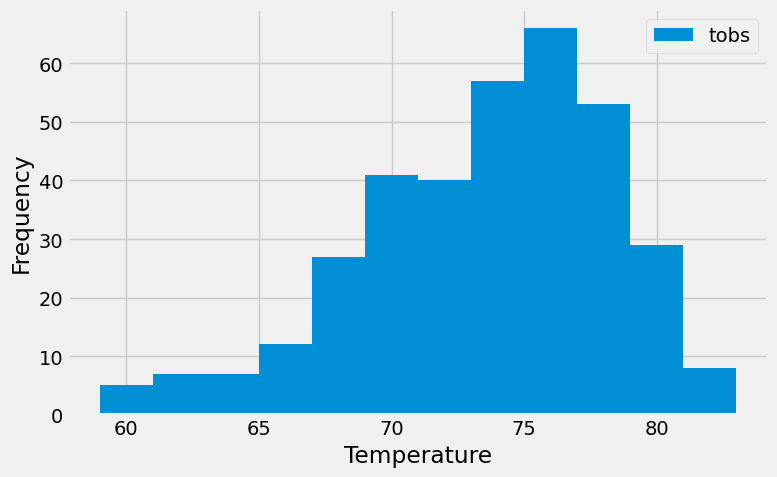

In [81]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_last_date = session.query(func.max(Measurement.date)).scalar()
temp_last_date = pd.to_datetime(temp_last_date) 
temp_one_year_ago = temp_last_date - pd.DateOffset(years=1)
temp_one_year_ago_str = temp_one_year_ago.strftime('%Y-%m-%d')  # Use temp_one_year_ago here

qry_tobs = (
    session.query(Measurement.tobs)
    .filter(Measurement.station == most_active_station_id)
    .filter(Measurement.date >= temp_one_year_ago_str)
    .all()
)

qry_tobs_df = pd.DataFrame(qry_tobs, columns=['tobs'])

qry_tobs_df.plot.hist(bins=12, figsize=(8, 5))
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# Close Session

In [82]:
# Close Session
session.close()